In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from spyglass.common import Session, IntervalList, Electrode, get_electrode_indices, interval_list_contains, interval_list_intersect
from spyglass.lfp.v1 import LFPV1
# from spyglass.lfp_band.v1 import LFPBandV1
from spyglass.position import PositionOutput
from spyglass.position.v1 import TrodesPosV1

import os
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from ms_opto_stim_protocol import OptoStimProtocol,OptoStimProtocolParams, OptoStimProtocolTransfected, OptoStimProtocolLaser, OptoStimProtocolClosedLoop
from Analysis.utils import filter_animal, filter_task
from Analysis.lfp_analysis import get_ref_electrode_index, power_spectrum
from Analysis.position_analysis import filter_position_ports

os.chdir('/home/sambray/Documents/MS_analysis/')
from ms_task_performance import AlternationTaskPerformance
from ms_dio_event import DioEvents, ProcessedDioEvents

from ms_task_identification import TaskIdentification
from ms_interval import EpochIntervalListName

In [3]:
(PositionOutput()& key & {"source":"TrodesPosV1"}).fetch1_dataframe()

NameError: name 'key' is not defined

In [15]:
(TrodesPosV1() & key).fetch1_dataframe()

,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,,
1.652911e+09,8.0,65.88,54.63,0.692315,-0.020076,-0.074622,0.077276
1.652911e+09,9.0,65.88,54.63,0.692315,-0.040736,-0.123487,0.130033
1.652911e+09,10.0,65.88,54.63,0.692315,-0.074628,-0.184666,0.199176
1.652911e+09,11.0,65.88,54.63,0.692315,-0.123496,-0.249642,0.278518
1.652911e+09,12.0,65.88,54.63,0.692315,-0.184676,-0.305164,0.356693
...,...,...,...,...,...,...,...
1.652912e+09,36306.0,26.76,6.93,0.253402,0.610197,0.100322,0.618389
1.652912e+09,36307.0,26.79,6.93,0.253130,0.554785,-0.021638,0.555206
1.652912e+09,36308.0,26.79,6.90,0.252080,0.466547,-0.125816,0.483214


In [9]:
track_type = "wtrack"
inbound_trial = []
trial_velocities = []
opto_trial = []
transfected_trial = []
accuracy = []
animal = ""



#################################
for transfected in [True,False]:
    dataset_key = {
                       # 'pulse_length_ms':40,
                       # "transfected":True,
                       "laser_power": 77,
                       'targeted_phase':90,
                        'animal':animal,
                        'transfected':transfected,
                        # "interval_list_name":"pos 3 valid times",
        }
        
    dataset = (OptoStimProtocol *
               OptoStimProtocolTransfected *
               OptoStimProtocolLaser *
               OptoStimProtocolClosedLoop) & dataset_key
    
    dataset = filter_animal(dataset,dataset_key['animal'])
    dataset = filter_task(dataset,track_type)
    
    
    for nwb_file_name,interval_name in zip(dataset.fetch("nwb_file_name"),dataset.fetch("interval_list_name")):
        key = {"nwb_file_name":nwb_file_name,"interval_list_name":interval_name}
        #outcomes and durations
        outcomes = ((AlternationTaskPerformance() * EpochIntervalListName)&key).fetch('performance_outcomes')[0]
        poke_times = ((ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName)& key).fetch1("dio_first_poke_times")
        last_poke_times = ((ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key).fetch1("dio_last_poke_times")
        inbound_trial.extend([('inbound' in x) for x in outcomes[1:]])
        accuracy.extend([('incorrect' in x) for x in outcomes[1:]])

        # speed
        pos_df = (TrodesPosV1() & key).fetch1_dataframe()
        timestamps = np.array(pos_df.index)
        speed = np.asarray(pos_df.speed)
        trial_intervals = [[poke_times[i],poke_times[i+1]] for i in range(len(poke_times)-1)]
        travel_intervals = np.array(filter_position_ports(key))
        for trial in trial_intervals:
            intervals = interval_list_intersect(np.array(trial)[None,:], travel_intervals)
            trial_velocities.append(np.concatenate([speed[np.where((timestamps>interval[0]) & (timestamps<interval[1]))[0]] for interval in intervals]))
    
        
        #Dio intervals
        test_intervals = (OptoStimProtocol() & key).fetch1("test_intervals")
        opto_trial.extend([interval_list_contains(test_intervals,np.array([i])).size for i in poke_times[1:]])

        #transfected
        transfected_trial.extend(np.ones(outcomes.size-1)*int(transfected))

# trial_durations = np.array(trial_durations)
inbound_trial = np.array(inbound_trial)
opto_trial = np.array(opto_trial).astype(bool)
transfected_trial = np.array(transfected_trial).astype(bool)
accuracy = ~np.array(accuracy).astype(bool)

wtrack_limit 30.300000000000097
wtrack_limit 28.59999999999952
wtrack_limit 31.199999999999854
wtrack_limit 29.37999999999982
wtrack_limit 32.95
wtrack_limit 30.99999999999994
wtrack_limit 34.30000000000001
wtrack_limit 28.630000000000067
wtrack_limit 32.24999999999994
wtrack_limit 30.759999999999938
wtrack_limit 33.949999999999946
wtrack_limit 29.70999999999985
wtrack_limit 31.749999999999954
wtrack_limit 31.95999999999986
wtrack_limit 32.0499999999999
wtrack_limit 30.639999999999965
wtrack_limit 28.32999999999928
wtrack_limit 26.77000000000004
wtrack_limit 28.330000000000048
wtrack_limit 28.54000000000019
wtrack_limit 30.249999999999773
wtrack_limit 29.649999999999714
wtrack_limit 30.670000000000023
wtrack_limit 27.940000000000055
wtrack_limit 30.519999999999946
wtrack_limit 30.339999999999918
wtrack_limit 27.610000000000166
wtrack_limit 30.939999999999607
wtrack_limit 30.94000000000011
wtrack_limit 30.760000000000005
wtrack_limit 27.489999999999903
wtrack_limit 27.880000000000052
wt

In [8]:
trial_durations

NameError: name 'trial_durations' is not defined

Text(0, 0.5, 'outbound trials')

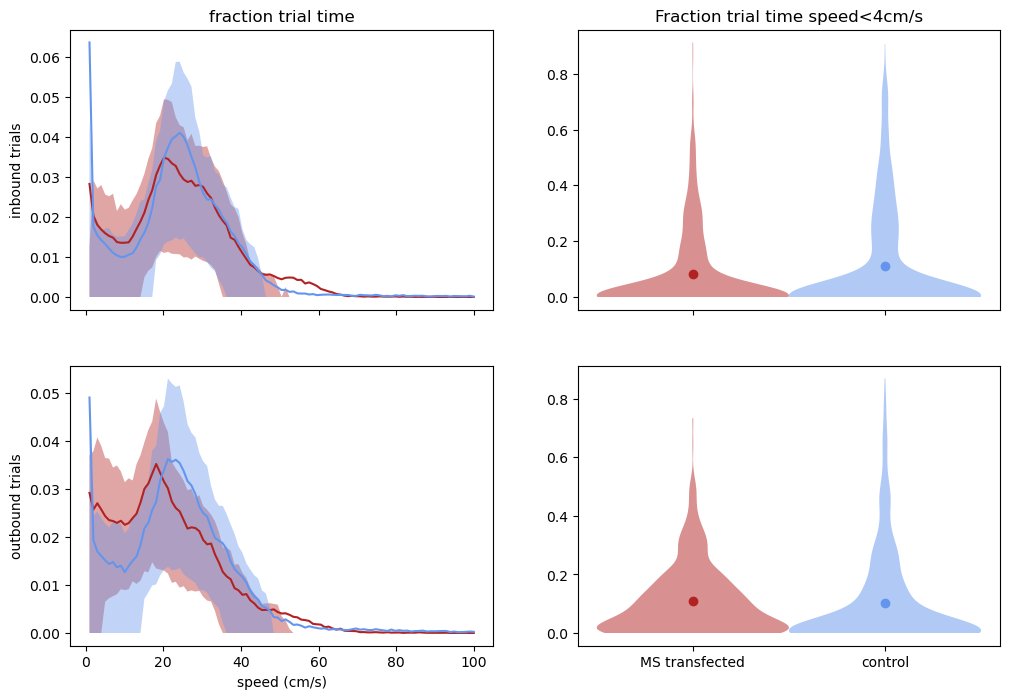

In [10]:
root_condition = (opto_trial)#& ~inbound_trial)
speed_thresh = 4

fig,ax_list = plt.subplots(ncols = 2,nrows=2,figsize=(12,8),sharex='col')
for ii,trial_type in enumerate([inbound_trial,~inbound_trial]):
    base_condition = root_condition & trial_type
    ax = ax_list[ii]
    for i,(filter,color) in enumerate(zip([transfected_trial,~transfected_trial],['firebrick','cornflowerblue'])):
        condition = base_condition & filter
        # velocity = np.concatenate(np.array(trial_velocities)[np.where(condition)[0]])
        # velocity = velocity[~np.isnan(velocity)]
        # val,bins = np.histogram(velocity,bins=np.linspace(0,200,100))
        # val = val/val.sum()
        # val = np.log10(val)
        # plt.plot(bins[1:],val,c=color)
        # plt.xlim(0,100)
        dist = []
        for velocity in np.array(trial_velocities)[np.where(condition)[0]]:
            velocity = velocity[~np.isnan(velocity)]
            val,bins = np.histogram(velocity,bins=np.linspace(0,100,100))
            val = val/val.sum()
            dist.append(val)
        dist = np.array(dist)
        ax[0].plot(bins[1:],np.mean(dist,axis=0),c=color)
        ax[0].fill_between(bins[1:],np.percentile(dist,25,axis=0),np.percentile(dist,75,axis=0),facecolor=color,alpha=.4)
    
        #stationary time
        ind_stationary = np.where(bins<speed_thresh)[0]
        stationary_fract = dist[:,ind_stationary].sum(axis=1)
        violin = ax[1].violinplot(stationary_fract,positions=[i/2],
                   showmedians=False,showextrema=False,points=1000,)
        for pc in violin['bodies']:
            pc.set_facecolor(color)
            pc.set_alpha(.5)
        ax[1].scatter([i/2],np.mean(stationary_fract),color = color)

ax[0].set_xlabel("speed (cm/s)")
ax_list[0,0].set_title("fraction trial time")
ax[1].set_xticks([0.,.5])
ax[1].set_xticklabels(["MS transfected","control"])
ax_list[0,1].set_title(f"Fraction trial time speed<{speed_thresh}cm/s")

ax_list[0,0].set_ylabel('inbound trials')
ax_list[1,0].set_ylabel('outbound trials')

In [87]:
dist.shape

(614, 99)

In [69]:
velocity = velocity[~np.isnan(velocity)]